# Setup

Before running this below codes, you would need to install and set the path for Graphviz on your machine. Here's how:
1) Install Graphviz: Download and install Graphviz from the official website: https://graphviz.org/download/
2) 
Add Graphviz to PATH:
On Windows:
After installing Graphviz, locate the directory where Graphviz is installed. The default installation path is usually C:\Program Files\Graphviz.
Copy the path to the 'bin' directory within the Graphviz installation directory (e.g., C:\Program Files\Graphviz\bin).
Open the Start menu, search for "Environment Variables", and click on "Edit the system environment variables".
In the System Properties window, click on the "Environment Variables..." button.
In the Environment Variables window, find the "Path" variable under "System variables" and click on "Edit...".
Click on "New" and paste the path to the 'bin' directory of Graphviz.
Click "OK" to save the changes.
Restart any open command prompts or Jupyter Notebooks for the changes to take effect.


# Training and Visualising a Decision Tree

To understand decision trees, let’s build one and take a look at how it makes predictions. The following code trains a DecisionTreeClassifier on the iris dataset

In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris(as_frame=True)
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values
y_iris = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

You can visualize the trained decision tree by first using the export_graphviz()
function to output a graph definition file called iris_tree.dot. Then you can use graphviz.Source.from_file() to load and display the file in a Jupyter notebook. Graphviz is an open source graph visualization software package. It also includes a
dot command-line tool to convert .dot files to a variety of formats, such as PDF or
PNG

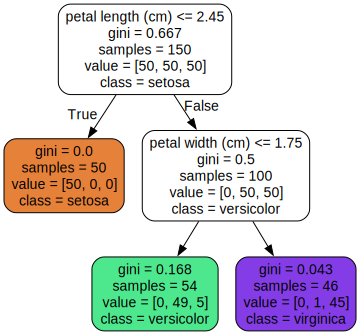

In [2]:
from sklearn.tree import export_graphviz
from pathlib import Path

IMAGES_PATH = Path() / "images" / "decision_trees"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
export_graphviz(
        tree_clf,
        out_file=str(IMAGES_PATH / "iris_tree.dot"),  # path differs in the book
        feature_names=["petal length (cm)", "petal width (cm)"],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )
from graphviz import Source

Source.from_file(IMAGES_PATH / "iris_tree.dot")

# Making Predictions

This below figure shows this decision tree’s decision boundaries. The thick vertical line
represents the decision boundary of the root node (depth 0): petal length = 2.45
cm. Since the lefthand area is pure (only Iris setosa), it cannot be split any further.
However, the righthand area is impure, so the depth-1 right node splits it at petal
width = 1.75 cm (represented by the dashed line). Since max_depth was set to 2, the
decision tree stops right there. If you set max_depth to 3, then the two depth-2 nodes
would each add another decision boundary (represented by the two vertical dotted
lines).

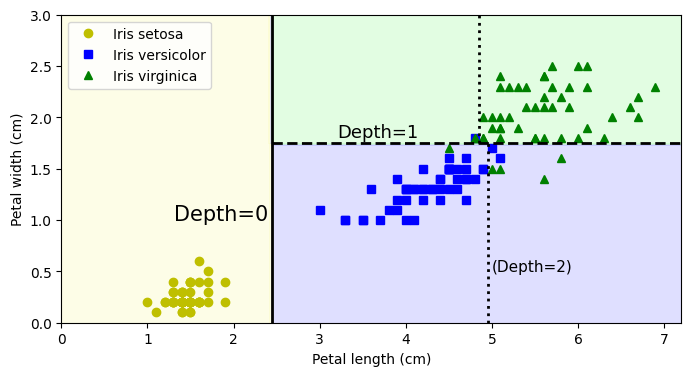

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# extra code – just formatting details
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
plt.figure(figsize=(8, 4))

lengths, widths = np.meshgrid(np.linspace(0, 7.2, 100), np.linspace(0, 3, 100))
X_iris_all = np.c_[lengths.ravel(), widths.ravel()]
y_pred = tree_clf.predict(X_iris_all).reshape(lengths.shape)
plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=custom_cmap)
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris[:, 0][y_iris == idx], X_iris[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

# extra code – this section beautifies figure
tree_clf_deeper = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf_deeper.fit(X_iris, y_iris)
th0, th1, th2a, th2b = tree_clf_deeper.tree_.threshold[[0, 2, 3, 6]]
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.plot([th0, th0], [0, 3], "k-", linewidth=2)
plt.plot([th0, 7.2], [th1, th1], "k--", linewidth=2)
plt.plot([th2a, th2a], [0, th1], "k:", linewidth=2)
plt.plot([th2b, th2b], [th1, 3], "k:", linewidth=2)
plt.text(th0 - 0.05, 1.0, "Depth=0", horizontalalignment="right", fontsize=15)
plt.text(3.2, th1 + 0.02, "Depth=1", verticalalignment="bottom", fontsize=13)
plt.text(th2a + 0.05, 0.5, "(Depth=2)", fontsize=11)
plt.axis([0, 7.2, 0, 3])
plt.legend()

plt.show()

You can access the tree structure via the tree_ attribute:

In [4]:
tree_clf.tree_

For more information, check out this class's documentation:

In [5]:
# help(sklearn.tree._tree.Tree) and in the last section below

# Estimating Class Probabilities

A decision tree can also estimate the probability that an instance belongs to a partic‐
ular class k. First it traverses the tree to find the leaf node for this instance, and
then it returns the ratio of training instances of class k in this node. For example,
suppose you have found a flower whose petals are 5 cm long and 1.5 cm wide. The
corresponding leaf node is the depth-2 left node, so the decision tree outputs the
following probabilities: 0% for Iris setosa (0/54), 90.7% for Iris versicolor (49/54), and
9.3% for Iris virginica (5/54). And if you ask it to predict the class, it outputs Iris
versicolor (class 1) because it has the highest probability. Let’s check this:

In [6]:
tree_clf.predict_proba([[5, 1.5]]).round(3)

array([[0.   , 0.907, 0.093]])

In [7]:
tree_clf.predict([[5, 1.5]])

array([1])

Perfect! Notice that the estimated probabilities would be identical anywhere else in
the bottom-right rectangle of figure above, if the petals were 6 cm long
and 1.5 cm wide (even though it seems obvious that it would most likely be an Iris
virginica in this case)

# Regularization Hyperparameters

Let’s test regularization on the moons dataset, introduced in the last lecture. We’ll train
one decision tree without regularization, and another with min_samples_leaf=5.
Here’s the code; Below figure shows the decision boundaries of each tree:

In [8]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=150, noise=0.2, random_state=42)

tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)
tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)

DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

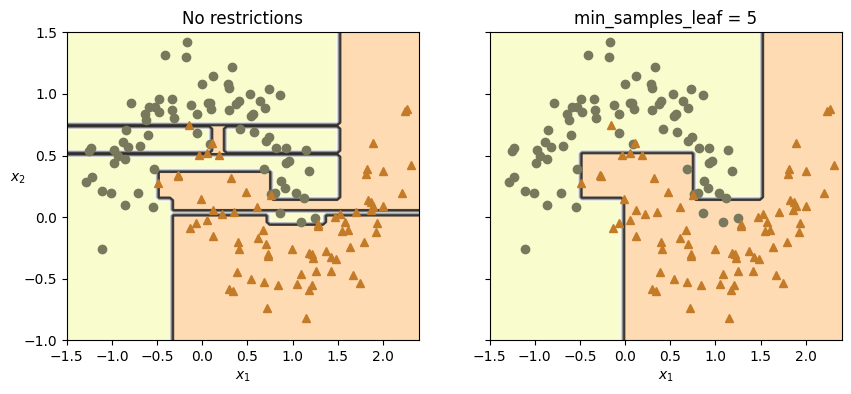

In [9]:
# extra code

def plot_decision_boundary(clf, X, y, axes, cmap):
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=cmap)
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8)
    colors = {"Wistia": ["#78785c", "#c47b27"], "Pastel1": ["red", "blue"]}
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[cmap][idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf1, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title("No restrictions")
plt.sca(axes[1])
plot_decision_boundary(tree_clf2, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title(f"min_samples_leaf = {tree_clf2.min_samples_leaf}")
plt.ylabel("")
plt.show()

The unregularized model on the left is clearly overfitting, and the regularized model
on the right will probably generalize better. We can verify this by evaluating both
trees on a test set generated using a different random seed:

In [10]:
X_moons_test, y_moons_test = make_moons(n_samples=1000, noise=0.2,
                                        random_state=43)
tree_clf1.score(X_moons_test, y_moons_test)

0.898

In [11]:
tree_clf2.score(X_moons_test, y_moons_test)

0.92

Indeed, the second tree has a better accuracy on the test set.

# Regression

Decision trees are also capable of performing regression tasks. Let’s build a regression
tree using Scikit-Learn’s DecisionTreeRegressor class, training it on a noisy quad‐
ratic dataset with max_depth=2.
Let's prepare a simple quadratic training set:

Code example:

In [12]:
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X_quad = np.random.rand(200, 1) - 0.5  # a single random input feature
y_quad = X_quad ** 2 + 0.025 * np.random.randn(200, 1)

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=2, random_state=42)

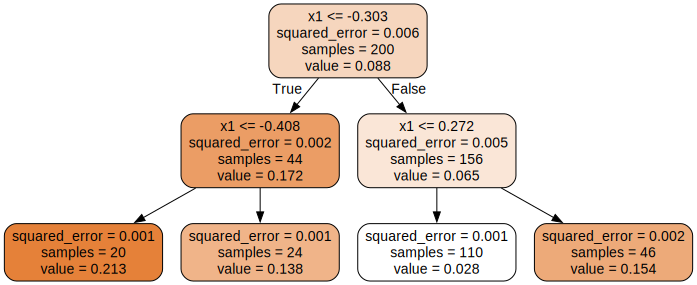

In [13]:
# extra code – we've already seen how to use export_graphviz()
export_graphviz(
    tree_reg,
    out_file=str(IMAGES_PATH / "regression_tree.dot"),
    feature_names=["x1"],
    rounded=True,
    filled=True
)
Source.from_file(IMAGES_PATH / "regression_tree.dot")

This tree looks very similar to the classification tree you built earlier. The main
difference is that instead of predicting a class in each node, it predicts a value. For
example, suppose you want to make a prediction for a new instance with x1 = 0.2. The
root node asks whether x1 ≤ 0.197. Since it is not, the algorithm goes to the right child
node, which asks whether x1 ≤ 0.772. Since it is, the algorithm goes to the left child
node. This is a leaf node, and it predicts value=0.111. This prediction is the average
target value of the 110 training instances associated with this leaf node, and it results
in a mean squared error equal to 0.015 over these 110 instances.

This model’s predictions are represented on the left in figure below. If you set
max_depth=3, you get the predictions represented on the right. Notice how the
predicted value for each region is always the average target value of the instances
in that region. The algorithm splits each region in a way that makes most training
instances as close as possible to that predicted value.

In [14]:
tree_reg2 = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_reg2.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=3, random_state=42)

In [15]:
tree_reg.tree_.threshold

array([-0.30265072, -0.40830374, -2.        , -2.        ,  0.27175756,
       -2.        , -2.        ])

In [16]:
tree_reg2.tree_.threshold

array([-0.30265072, -0.40830374, -0.45416115, -2.        , -2.        ,
       -0.37022041, -2.        , -2.        ,  0.27175756, -0.21270403,
       -2.        , -2.        ,  0.40399227, -2.        , -2.        ])

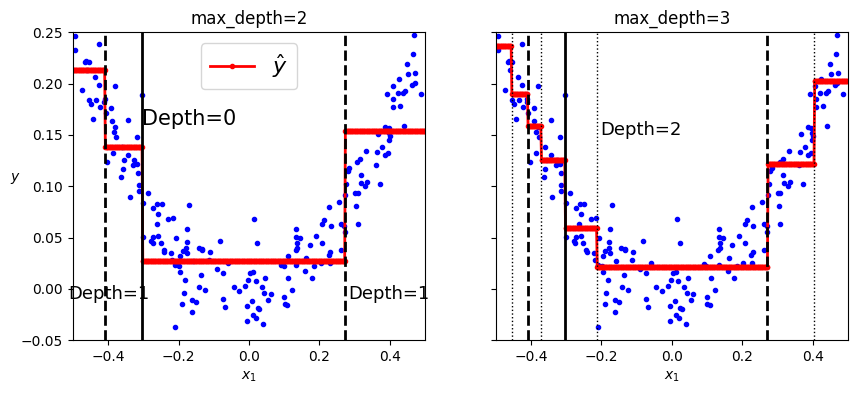

In [17]:
# extra code 

def plot_regression_predictions(tree_reg, X, y, axes=[-0.5, 0.5, -0.05, 0.25]):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$")
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg, X_quad, y_quad)

th0, th1a, th1b = tree_reg.tree_.threshold[[0, 1, 4]]
for split, style in ((th0, "k-"), (th1a, "k--"), (th1b, "k--")):
    plt.plot([split, split], [-0.05, 0.25], style, linewidth=2)
plt.text(th0, 0.16, "Depth=0", fontsize=15)
plt.text(th1a + 0.01, -0.01, "Depth=1", horizontalalignment="center", fontsize=13)
plt.text(th1b + 0.01, -0.01, "Depth=1", fontsize=13)
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper center", fontsize=16)
plt.title("max_depth=2")

plt.sca(axes[1])
th2s = tree_reg2.tree_.threshold[[2, 5, 9, 12]]
plot_regression_predictions(tree_reg2, X_quad, y_quad)
for split, style in ((th0, "k-"), (th1a, "k--"), (th1b, "k--")):
    plt.plot([split, split], [-0.05, 0.25], style, linewidth=2)
for split in th2s:
    plt.plot([split, split], [-0.05, 0.25], "k:", linewidth=1)
plt.text(th2s[2] + 0.01, 0.15, "Depth=2", fontsize=13)
plt.title("max_depth=3")

plt.show()

Just like for classification tasks, decision trees are prone to overfitting when dealing
with regression tasks. Without any regularization (i.e., using the default hyperpara‐
meters), you get the predictions on the left in figure below. These predictions are
obviously overfitting the training set very badly. Just setting min_samples_leaf=10
results in a much more reasonable model, represented on the right in figure below.

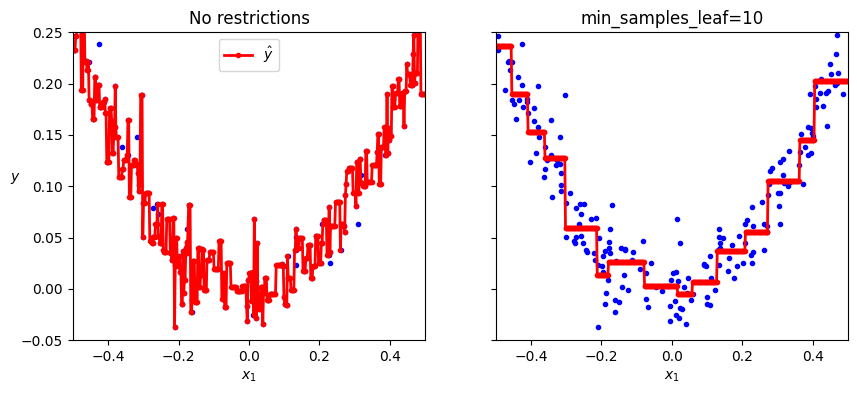

In [18]:
# extra code 

tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X_quad, y_quad)
tree_reg2.fit(X_quad, y_quad)

x1 = np.linspace(-0.5, 0.5, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X_quad, y_quad, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([-0.5, 0.5, -0.05, 0.25])
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper center")
plt.title("No restrictions")

plt.sca(axes[1])
plt.plot(X_quad, y_quad, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([-0.5, 0.5, -0.05, 0.25])
plt.xlabel("$x_1$")
plt.title(f"min_samples_leaf={tree_reg2.min_samples_leaf}")

plt.show()

# Sensitivity to axis orientation

Figure below shows a simple linearly separable dataset: on the left, a decision tree can split it easily,
while on the right, after the dataset is rotated by 45°, the decision boundary looks
unnecessarily convoluted. Although both decision trees fit the training set perfectly, it
is very likely that the model on the right will not generalize well.

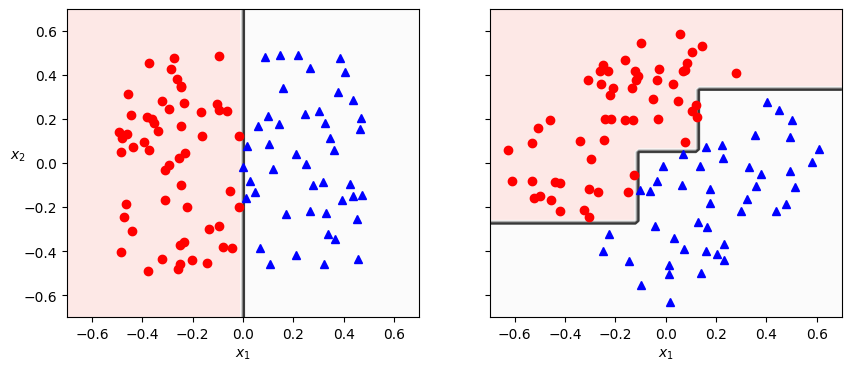

In [19]:
# extra code

np.random.seed(6)
X_square = np.random.rand(100, 2) - 0.5
y_square = (X_square[:, 0] > 0).astype(np.int64)

angle = np.pi / 4  # 45 degrees
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                            [np.sin(angle), np.cos(angle)]])
X_rotated_square = X_square.dot(rotation_matrix)

tree_clf_square = DecisionTreeClassifier(random_state=42)
tree_clf_square.fit(X_square, y_square)
tree_clf_rotated_square = DecisionTreeClassifier(random_state=42)
tree_clf_rotated_square.fit(X_rotated_square, y_square)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_square, X_square, y_square,
                       axes=[-0.7, 0.7, -0.7, 0.7], cmap="Pastel1")
plt.sca(axes[1])
plot_decision_boundary(tree_clf_rotated_square, X_rotated_square, y_square,
                       axes=[-0.7, 0.7, -0.7, 0.7], cmap="Pastel1")
plt.ylabel("")

plt.show()

One way to limit this problem is to scale the data, then apply a principal component
analysis transformation. We will look at PCA in detail in coming weeks, but for now you only need to know that it rotates the data in a way that reduces the correlation
between the features, which often (not always) makes things easier for trees.
Let’s create a small pipeline that scales the data and rotates it using PCA, then train a
DecisionTreeClassifier on that data. Figurebelow8 shows the decision boundaries of
that tree: as you can see, the rotation makes it possible to fit the dataset pretty well
using only one feature, z1, which is a linear function of the original petal length and
width. Here’s the code:

In [20]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pca_pipeline = make_pipeline(StandardScaler(), PCA())
X_iris_rotated = pca_pipeline.fit_transform(X_iris)
tree_clf_pca = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf_pca.fit(X_iris_rotated, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

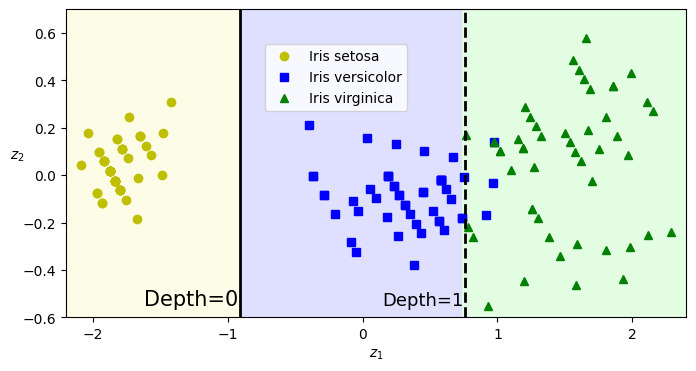

In [21]:
# extra code 

plt.figure(figsize=(8, 4))

axes = [-2.2, 2.4, -0.6, 0.7]
z0s, z1s = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                       np.linspace(axes[2], axes[3], 100))
X_iris_pca_all = np.c_[z0s.ravel(), z1s.ravel()]
y_pred = tree_clf_pca.predict(X_iris_pca_all).reshape(z0s.shape)

plt.contourf(z0s, z1s, y_pred, alpha=0.3, cmap=custom_cmap)
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris_rotated[:, 0][y_iris == idx],
             X_iris_rotated[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
th1, th2 = tree_clf_pca.tree_.threshold[[0, 2]]
plt.plot([th1, th1], axes[2:], "k-", linewidth=2)
plt.plot([th2, th2], axes[2:], "k--", linewidth=2)
plt.text(th1 - 0.01, axes[2] + 0.05, "Depth=0",
         horizontalalignment="right", fontsize=15)
plt.text(th2 - 0.01, axes[2] + 0.05, "Depth=1",
         horizontalalignment="right", fontsize=13)
plt.axis(axes)
plt.legend(loc=(0.32, 0.67))


plt.show()

# Decision Trees Have High Variance

We've seen that small changes in the dataset (such as a rotation) may produce a very different Decision Tree. Now let's show that training the same model on the same data may produce a very different model every time, since the CART training algorithm used by Scikit-Learn is stochastic. To show this, we will set random_state to a different value than earlier:

In [22]:
tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=40)

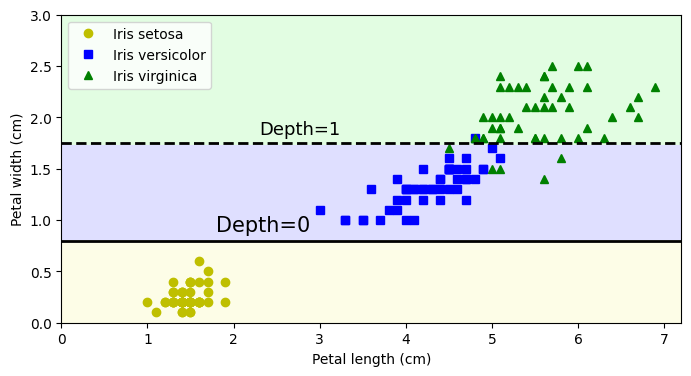

In [23]:
# extra code 

plt.figure(figsize=(8, 4))
y_pred = tree_clf_tweaked.predict(X_iris_all).reshape(lengths.shape)
plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=custom_cmap)

for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris[:, 0][y_iris == idx], X_iris[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

th0, th1 = tree_clf_tweaked.tree_.threshold[[0, 2]]
plt.plot([0, 7.2], [th0, th0], "k-", linewidth=2)
plt.plot([0, 7.2], [th1, th1], "k--", linewidth=2)
plt.text(1.8, th0 + 0.05, "Depth=0", verticalalignment="bottom", fontsize=15)
plt.text(2.3, th1 + 0.05, "Depth=1", verticalalignment="bottom", fontsize=13)
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.axis([0, 7.2, 0, 3])
plt.legend()

plt.show()

As you can see, it looks very different from the previous decision tree figure (in the Making Predictions sectio above). Luckily, by averaging predictions over many trees, it’s possible to reduce variance significantly. Such an ensemble of trees is called a random forest, and it’s one of the
most powerful types of models available today, as you will see in the next chapter.

# Extra Material – Accessing the tree structure

A trained DecisionTreeClassifier has a tree_ attribute that stores the tree's structure:

In [24]:
tree = tree_clf.tree_
tree

You can get the total number of nodes in the tree:

In [25]:
tree.node_count

5

And other self-explanatory attributes are available:

In [26]:
tree.max_depth

2

In [27]:
tree.max_n_classes

3

In [28]:
tree.n_features

2

In [29]:
tree.n_outputs

1

In [30]:
tree.n_leaves

3

All the information about the nodes is stored in NumPy arrays. For example, the impurity of each node:

In [31]:
tree.impurity

array([0.66666667, 0.        , 0.5       , 0.16803841, 0.04253308])

The root node is at index 0. The left and right children nodes of node i are tree.children_left[i] and tree.children_right[i]. For example, the children of the root node are:

In [32]:
tree.children_left[0], tree.children_right[0]

(1, 2)

When the left and right nodes are equal, it means this is a leaf node (and the children node ids are arbitrary):

In [33]:
tree.children_left[3], tree.children_right[3]

(-1, -1)

So you can get the leaf node ids like this:

In [34]:
is_leaf = (tree.children_left == tree.children_right)
np.arange(tree.node_count)[is_leaf]

array([1, 3, 4])

Non-leaf nodes are called split nodes. The feature they split is available via the feature array. Values for leaf nodes should be ignored:

In [35]:
tree.feature

array([ 0, -2,  1, -2, -2], dtype=int64)

And the corresponding thresholds are:

In [36]:
tree.threshold

array([ 2.44999999, -2.        ,  1.75      , -2.        , -2.        ])

And the number of instances per class that reached each node is available too:

In [37]:
tree.value

array([[[50., 50., 50.]],

       [[50.,  0.,  0.]],

       [[ 0., 50., 50.]],

       [[ 0., 49.,  5.]],

       [[ 0.,  1., 45.]]])

In [38]:
tree.n_node_samples

array([150,  50, 100,  54,  46], dtype=int64)

In [39]:
np.all(tree.value.sum(axis=(1, 2)) == tree.n_node_samples)

True

Here's how you can compute the depth of each node:

In [40]:
def compute_depth(tree_clf):
    tree = tree_clf.tree_
    depth = np.zeros(tree.node_count)
    stack = [(0, 0)]
    while stack:
        node, node_depth = stack.pop()
        depth[node] = node_depth
        if tree.children_left[node] != tree.children_right[node]:
            stack.append((tree.children_left[node], node_depth + 1))
            stack.append((tree.children_right[node], node_depth + 1))
    return depth

depth = compute_depth(tree_clf)
depth

array([0., 1., 1., 2., 2.])

Here's how to get the thresholds of all split nodes at depth 1:

In [41]:
tree_clf.tree_.feature[(depth == 1) & (~is_leaf)]

array([1], dtype=int64)

In [42]:
tree_clf.tree_.threshold[(depth == 1) & (~is_leaf)]

array([1.75])